### Setup

In [1]:
import networkx as nx
from networkx.algorithms import bipartite

import itertools
import random
from math import ceil
# import numpy as np

from time import perf_counter
# from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm

# import matplotlib as mpl
import matplotlib.pyplot as plt

### Utility functions

In [2]:
def draw_edge_set(Gu, edges):
    colors = []
    for (u,v) in Gu.edges:
        if (u,v) in edges or (v,u) in edges:
            colors.append("red")
        else:
            colors.append("black")

    nx.draw_networkx(Gu, edge_color=colors)

In [3]:
def get_path_weight(G, path):
    total_weight = 0
    for u,v in zip(path, path[1:]):
        total_weight += G.edges[u,v]['weight']
    return total_weight

In [4]:
def contract(u,v):
    w1 = G.edges[u[-1],v[0]]['weight']
    w2 = G.edges[v[-1],u[0]]['weight']
    if w1 > w2:
        return u + v, w1
    else:
        return v + u, w2

In [5]:
def info(string, verbose):
    if verbose:
        print(f"%%% {string} %%%")

### Solvers

In [6]:
def via_brute_force(G, n, verbose=False):
    path = None
    w_max = 0
    for p in itertools.permutations(range(n)):
        w = get_path_weight(G, p)
        if w > w_max:
            path = p
            w_max = w
    return path

In [7]:
def via_matching(G, n, verbose=False):
    Gu = nx.complete_graph(n)
    for u,v in Gu.edges:
        w1 = G.edges[u,v]['weight']
        w2 = G.edges[v,u]['weight']
        Gu.edges[u,v]['weight'] = max(w1, w2)

    matching = nx.max_weight_matching(Gu)

    dir_matching = []
    for u,v in matching:
        if G.edges[u,v]['weight'] > G.edges[v,u]['weight']:
            dir_matching.append((u,v))
        else:
            dir_matching.append((v,u))
    # draw_edge_set(Gu, dir_matching)

    path = []
    for u,v in dir_matching:
        path.append(u)
        path.append(v)
    if n % 2 == 1:
        vertex_sum = n * (n-1) / 2
        final_v = int(vertex_sum - sum(path))
        path.append(final_v)
    
    return path

In [8]:
def via_iterated_matching(G, n, verbose=False):
    Gk = nx.complete_graph([(i,) for i in range(n)])
    for u in Gk.nodes:
        Gk.nodes[u]['value'] = u[0]
    for u,v in Gk.edges:
        _,w = contract(u,v)
        Gk.edges[u,v]['weight'] = w

    num_nodes = n
    while num_nodes > 1:
        info(f"num nodes: {num_nodes}", verbose)
        
        Gk_old = Gk
        Gk = nx.Graph()

        matching = nx.max_weight_matching(Gk_old)

        if num_nodes % 2 == 1:
            value_sum = n * (n-1) / 2
            for u,v in matching:
                value_sum -= Gk_old.nodes[u]['value'] + Gk_old.nodes[v]['value']
            final_value = int(value_sum)
            for u in Gk_old.nodes:
                if Gk_old.nodes[u]['value'] == final_value:
                    fluke = False
                    for x,y in matching:
                        if u in (x,y):
                            fluke = True
                    if not fluke:
                        Gk.add_node(u)
                        Gk.nodes[u]['value'] = final_value

        for u,v in matching:
            node,_ = contract(u,v)
            Gk.add_node(node)
            Gk.nodes[node]['value'] = Gk_old.nodes[u]['value'] + Gk_old.nodes[v]['value']

        for u in Gk.nodes:
            for v in Gk.nodes:
                if u != v:
                    _,w = contract(u,v)
                    Gk.add_edge(u, v, weight=w)

        num_nodes = len(Gk.nodes)

    for u in Gk.nodes:
        assert Gk.nodes[u]['value'] == n * (n-1) / 2

    return list(Gk.nodes)[0]

WARNING: NetworkX uses an assignment problem solver other than the Hungarian method

In [9]:
def via_cycle_cover(G, n, verbose=False):
    Gb = nx.Graph()
    for i in range(2*n):
        Gb.add_node(i)
    for u,v in G.edges:
        Gb.add_edge(u, v+n, weight=1-G.edges[u,v]['weight'])  # account for min weight NetworkX method

    mb_dict = bipartite.minimum_weight_full_matching(Gb, top_nodes=list(Gb.nodes)[:n])
    # draw_edge_set(Gb, list(mb_dict.items()))

    m_dict = {}
    for u,v in mb_dict.items():
        if u < n:
            x,y = u,v
        else:
            x,y = v,u
        m_dict[x] = y-n
    # draw_edge_set(Gu, list(m_dict.items()))


    cycle_cover = []

    done = set()
    cycle = []
    start = curr = 0

    while True:
        cycle.append(curr)
        done.add(curr)
        curr = m_dict[curr]
        if curr == start:
            cycle_cover.append(cycle)
            cycle = []
            flag = False
            for i in range(n):
                if i not in done:
                    start = curr = i
                    flag = True
                    break
            if not flag:
                break

    path_cover = []
    for cycle in cycle_cover:
        best_start = cycle[0]
        best_start_idx = 0
        min_weight = G.edges[cycle[-1],cycle[0]]['weight']
        for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
            if G.edges[u,v]['weight'] < min_weight:
                best_start = v
                best_start_idx = i+1
                min_weight = G.edges[u,v]['weight']
        path = cycle[best_start_idx:] + cycle[:best_start_idx]
        path_cover.append(path)

    return list(itertools.chain(*path_cover))

In [10]:
def via_iterated_cycle_cover(G, n, verbose=False):
    Gk = nx.complete_graph([(i,) for i in range(n)], nx.DiGraph())
    num_nodes = n  
    
    while num_nodes > 1:
        info(f"num nodes: {num_nodes}", verbose)
        
        Gb = nx.Graph()
        for u in Gk.nodes:
            Gb.add_node(u)
            Gb.add_node(tuple([i + n for i in u]))
        for u,v in Gk.edges:
            Gb.add_edge(u, tuple([i + n for i in v]), weight=1-G.edges[u[-1],v[0]]['weight'])  # account for min weight NetworkX method
        
        mb_dict = bipartite.minimum_weight_full_matching(Gb, top_nodes=list(Gb.nodes)[::2])
        # draw_edge_set(Gb, list(mb_dict.items()))

        m_dict = {}
        for u,v in mb_dict.items():
            if u[0] < n:
                x,y = u,v
            else:
                x,y = v,u
            m_dict[x] = tuple([i - n for i in y])
        # draw_edge_set(Gu, list(m_dict.items()))


        cycle_cover = []

        done = set()
        cycle = []
        start = curr = random.choice([*m_dict])  # start with random node

        while True:
            cycle.extend(curr)
            done.add(curr)
            curr = m_dict[curr]
            if curr == start:
                cycle_cover.append(cycle)
                cycle = []
                flag = False
                for i in [*m_dict]:
                    if i not in done:
                        start = curr = i
                        flag = True
                        break
                if not flag:
                    break

        path_cover = []
        for cycle in cycle_cover:
            best_start = cycle[0]
            best_start_idx = 0
            min_weight = G.edges[cycle[-1],cycle[0]]['weight']
            for i, (u,v) in enumerate(zip(cycle, cycle[1:])):
                if G.edges[u,v]['weight'] < min_weight:
                    best_start = v
                    best_start_idx = i+1
                    min_weight = G.edges[u,v]['weight']
            path = cycle[best_start_idx:] + cycle[:best_start_idx]
            path_cover.append(tuple(path))
        
        Gk = nx.DiGraph()
        for u in path_cover:
            Gk.add_node(u)
        for u in Gk.nodes:
            for v in Gk.nodes:
                if u != v:
                    Gk.add_edge(u,v)
        num_nodes = len(Gk.nodes)

    return list(Gk.nodes)[0]

### Experiments

In [11]:
n = 100
G = nx.complete_graph(n, nx.DiGraph())
for (u,v) in G.edges:
    G.edges[u,v]['weight'] = random.random()

In [14]:
solvers = [via_matching, via_iterated_matching, via_cycle_cover, via_iterated_cycle_cover]
# solvers = [via_cycle_cover, via_iterated_cycle_cover]

solver_names = [func.__name__[4:].replace('_', ' ') for func in solvers]

In [15]:
for func, name in zip(solvers, solver_names):
    print(f"solver: {name}")
    start = perf_counter()
    p = func(G, n, verbose=True)
    t = perf_counter() - start
    w = get_path_weight(G, p)
    print(f"weight: {w}\ntime (s): {t}\n")

solver: matching
weight: 72.07593937722349
time (s): 1.2736012999994273

solver: iterated matching
weight: 96.08796533225706
time (s): 1.3154963999986649

solver: cycle cover
weight: 96.85724700458049
time (s): 0.3902165999988938

solver: iterated cycle cover
weight: 97.2801913754939
time (s): 0.09039160000065749



In [16]:
n_domain = range(10, 100, 10)

In [17]:
weights = []
times = []
for n in tqdm(n_domain):
    G = nx.complete_graph(n, nx.DiGraph())
    for (u,v) in G.edges:
        G.edges[u,v]['weight'] = random.random()
    
    inner_weights = []
    inner_times = []
    for func in solvers:
        first = True
        iterations = 5  # 5 is the standard in the timeit module
        for i in range(iterations):
            start = perf_counter()
            p = func(G, n)
            t = perf_counter() - start
            w = get_path_weight(G, p)
            if first:
                time_min = t
                first = False
            else:
                time_min = min(time_min, t)  
        inner_weights.append(w)  # the solvers are deterministic
        inner_times.append(time_min)
    weights.append(inner_weights)
    times.append(inner_times)

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.91s/it]


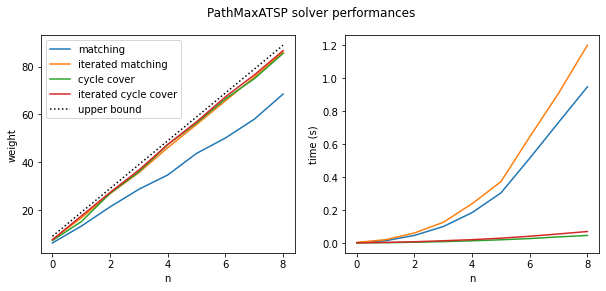

In [18]:
# %matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('PathMaxATSP solver performances')

axes[0].plot(weights, label=solver_names)
axes[0].plot([n-1 for n in n_domain], label='upper bound', color='black', linestyle=':')
axes[0].set_xlabel('n')
axes[0].set_ylabel('weight')

axes[1].plot(times)
axes[1].set_xlabel('n')
axes[1].set_ylabel('time (s)')

axes[0].legend()
# axes[1].legend()